In [1]:
# import libraries
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import json
from scipy.stats import  zscore
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import geopandas as gpd



# Kort introduktion

Koden i dette dokument beskriver udelukkende udformningen af en simpel figur for den kommunale træfsikkerhed.

In [5]:
# Fremgangsmåden er tilsavrende til den i filen "XGBoost_og_SHAP.ipynb"
df = pd.read_csv("XGBoost_data.csv")
df['price'] = np.log(df['price'])
z_scores = zscore(df['price'])
z_score_threshold = 3
mask = (z_scores >= -z_score_threshold) & (z_scores <= z_score_threshold)
df = df[mask]
df = df.drop(['date','point', 'price_per_sqm','discount', 'epoch'], axis=1)
df['price'] = np.exp(df['price']) 

In [6]:
df['badtoi'] = df['AntalBad'] + df['AntalToilet']
df.drop(['AntalBad','AntalToilet'],axis=1,inplace=True)
scaler = StandardScaler()
minmax = MinMaxScaler()
df['weighted_price'] = scaler.fit_transform(df[['weighted_price']])
df['dist_coast'] = minmax.fit_transform(df[['dist_coast']])
df['dist_highway'] = minmax.fit_transform(df[['dist_highway']])
df['dist_railroads'] = minmax.fit_transform(df[['dist_railroads']])
df['dist_airports'] = minmax.fit_transform(df[['dist_airports']])
df['dist_school'] = minmax.fit_transform(df[['dist_school']])
df['dist_kindergarden'] = minmax.fit_transform(df[['dist_kindergarden']])
df['dist_waterlines'] = minmax.fit_transform(df[['dist_waterlines']])
df['dist_forests'] = minmax.fit_transform(df[['dist_forests']])

In [9]:
# Følger modelopbyggelse fra "XGBoost_og_SHAP.ipynb" for rækkehus og loader pre-trænet model
# Beregner tillige de enkelte procentvise afvigelser
Model_variation = 'Rækkehus'
Rækkehuse = df[df['anvendelse'] == Model_variation]
Rækkehuse = Rækkehuse.drop('Sogn', axis=1)
data_dum = pd.get_dummies(Rækkehuse, prefix_sep='_' , drop_first=True)
X = data_dum.drop('price', axis=1)
y = data_dum['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_filename = f"Trænede modeller/{Model_variation}_endelig.joblib"
loaded_model = joblib.load(model_filename)
X_test['afvigelse'] = np.abs(loaded_model.predict(X_test) - y_test) / y_test * 100
rækhus = X_test[['latitude','longitude','afvigelse']].copy()


In [10]:
# Følger modelopbyggelse fra "XGBoost_og_SHAP.ipynb" for Enfamiliehus og loader pre-trænet model
# Beregner tillige de enkelte procentvise afvigelser
Model_variation = 'Enfamiliehus'
Enfamiliehus = df[df['anvendelse'] == Model_variation]
Enfamiliehus = Enfamiliehus.drop('Sogn', axis=1)
data_dum = pd.get_dummies(Enfamiliehus, prefix_sep='_' , drop_first=True)
X = data_dum.drop('price', axis=1)
y = data_dum['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_filename = f"Trænede modeller/{Model_variation}_endelig.joblib"
loaded_model = joblib.load(model_filename)
X_test['afvigelse'] = np.abs(loaded_model.predict(X_test) - y_test) / y_test * 100
enfamhus = X_test[['latitude','longitude','afvigelse']].copy()


In [11]:
# Følger modelopbyggelse fra "XGBoost_og_SHAP.ipynb" for Ejerlejligheder og loader pre-trænet model
# Beregner tillige de enkelte procentvise afvigelser
Model_variation = 'Ejerlejlighed'
Ejerlejlighed = df[df['anvendelse'] == Model_variation]
Ejerlejlighed = Ejerlejlighed.drop('Sogn', axis=1)
data_dum = pd.get_dummies(Ejerlejlighed, prefix_sep='_' , drop_first=True)
X = data_dum.drop('price', axis=1)
y = data_dum['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_filename = f"Trænede modeller/{Model_variation}_endelig.joblib"
loaded_model = joblib.load(model_filename)
X_test['afvigelse'] = np.abs(loaded_model.predict(X_test) - y_test) / y_test * 100
ejerlejl = X_test[['latitude','longitude','afvigelse']].copy()


In [100]:
# Sammenfatter alle resultater af testsættene for alle modellerne
samlet_afvigelse = pd.concat([rækhus, enfamhus, ejerlejl], axis=0).reset_index(drop=True)

In [101]:
# Loader GEODATA fra University of California, Berkeley
municipalities_gdf = gpd.read_file('/Users/patrickprintz/Desktop/Universitet/Projekter/9. Semester projekt/Endelig kodning og dataset/data/DNK_adm2.shp')
municipalities_gdf = municipalities_gdf.to_crs('EPSG:4326')
municipalities_gdf.rename(columns={'NAME_2': 'Municipality'}, inplace=True)
municipalities_gdf = municipalities_gdf[['Municipality', 'geometry']]

In [102]:
# Skaber points i stedet for longitude latitude koordinater
from shapely.geometry import Point
houses_geometry = [Point(lon, lat) for lon, lat in zip(samlet_afvigelse['longitude'], samlet_afvigelse['latitude'])]
houses_gdf = gpd.GeoDataFrame(samlet_afvigelse, geometry=houses_geometry, crs=municipalities_gdf.crs)


In [103]:
# Lægger GEODATA og afvigelser sammen og beregner andel af afvigelser under 20%
joined_gdf = gpd.sjoin(houses_gdf, municipalities_gdf, how='left', op='within')
municipality_count = joined_gdf.groupby('Municipality')['afvigelse'].count().reset_index()
afvigelse_below_20 = joined_gdf[joined_gdf['afvigelse'] > 20].groupby('Municipality')['afvigelse'].count().reset_index()
Andel_afvigelse_under_20 = pd.merge(municipality_count,afvigelse_below_20, on='Municipality')
Andel_afvigelse_under_20['andel'] = Andel_afvigelse_under_20['afvigelse_y'] / Andel_afvigelse_under_20['afvigelse_x'] * 100
Andel_afvigelse_under_20 = Andel_afvigelse_under_20[['Municipality','andel']]


municipalities_gdf = municipalities_gdf.merge(Andel_afvigelse_under_20, on='Municipality', how='left')

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


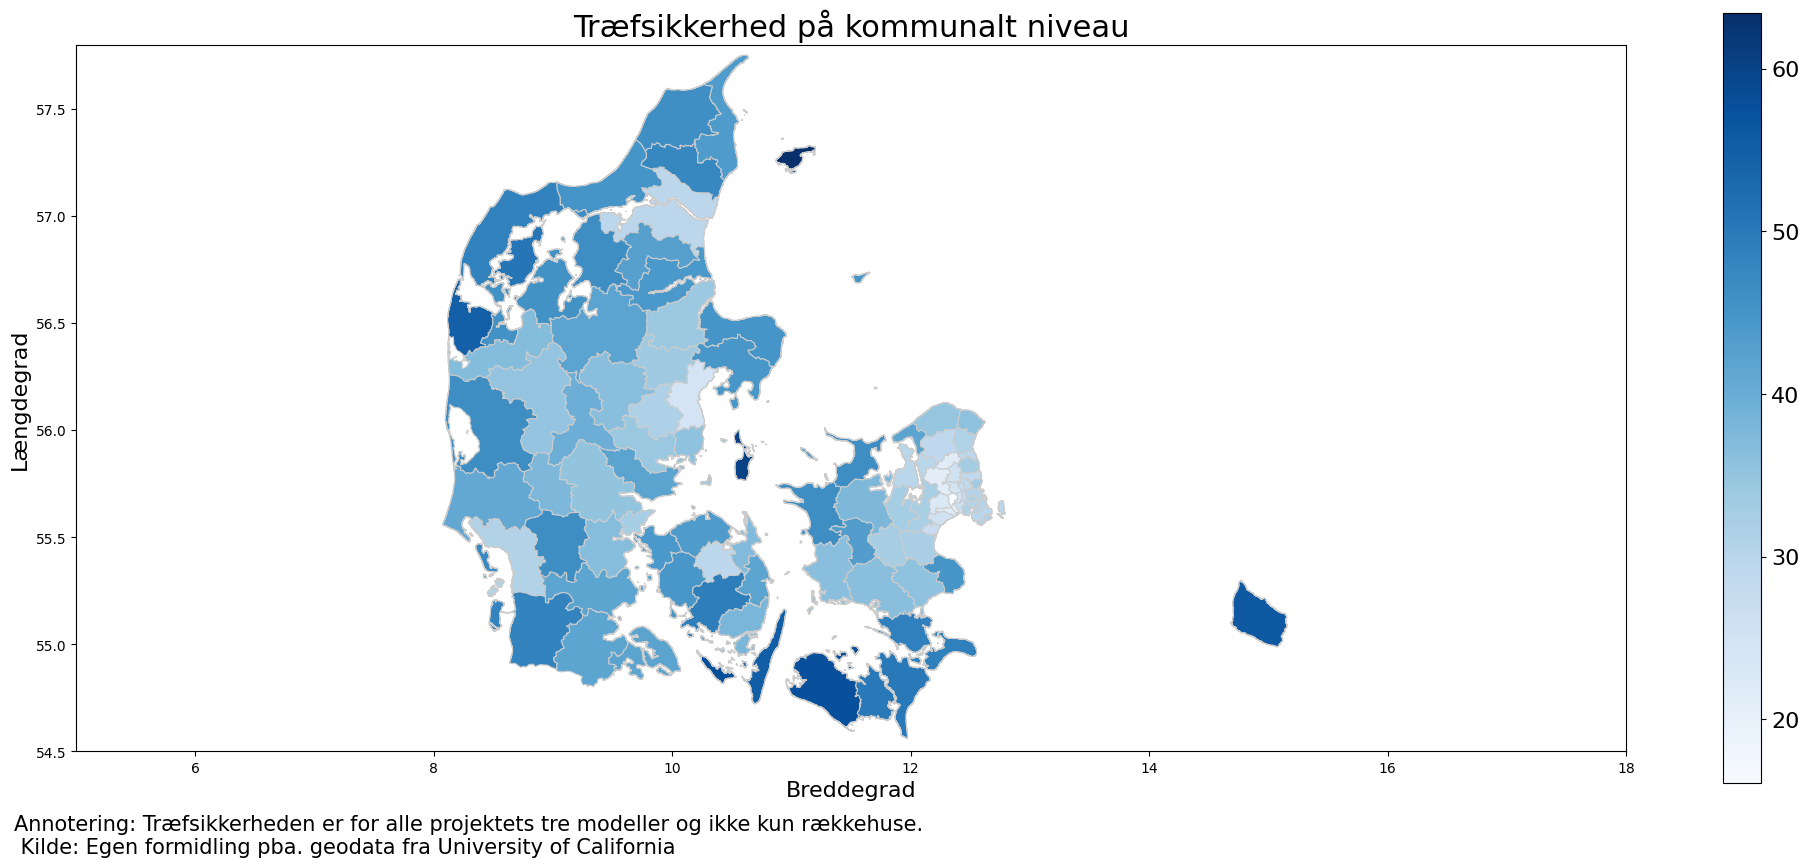

In [164]:
# Plotter figuren
fig, ax = plt.subplots(figsize=(25 , 10))
municipalities_gdf.plot(column='andel', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, vmin=municipalities_gdf['andel'].min(), vmax=municipalities_gdf['andel'].max())

plt.xlabel('Breddegrad', fontsize=16)
plt.ylabel('Længdegrad', fontsize=16)
plt.title('Træfsikkerhed på kommunalt niveau', fontsize=22)
ax.set_xlim([5, 18])
ax.set_ylim([54.5, 57.8])
footnote_text = 'Annotering: Træfsikkerheden er for alle projektets tre modeller og ikke kun rækkehuse.\n Kilde: Egen formidling pba. geodata fra University of California'
plt.figtext(0.1, 0.040, footnote_text, ha='left', fontsize=15, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))
cbar = plt.gcf().get_axes()[1]
cbar.tick_params(labelsize=16)

plt.show()
